In [1]:
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import helper_fcns as hlp
import autoreload
from scipy.stats import norm
matplotlib.style.use('plt_style.mplstyle')
%matplotlib inline

In [2]:
dataDir = 'data/';
whichFiles = 'toAnalyze.txt';
dataList = open(dataDir + whichFiles, 'r')
dFiles = dataList.readlines(-1)
dFiles = [x.strip('\n') for x in dFiles]
dataList.close()

In [3]:
dFiles = dFiles[5:] # ignore the first 4 sessions - early training

In [4]:
sfIdx = 0;
conIdx = 1;
dispIdx = 2;
nInd = 3; # 3 indices per stimulus; add 3 to all of the above indices to get the equivalent value for the second stimulus
subjRespIdx = 2*nInd;
refIdx = subjRespIdx + 1; # which interval contained reference is after the subject's response in the data format

In [5]:
stim1 = 39; stim2 = 41; # subject responses (asked which stimulus has higher SF)

In [6]:
data = [];
for df in dFiles:
    currData = np.loadtxt(dataDir + df);
    if df == dFiles[0]:
        data = currData;
    else:
        data = np.concatenate((data, currData), axis = 0);

sfVals = np.union1d(np.unique(data[:, sfIdx]), np.unique(data[:, sfIdx+nInd]))
conVals = np.union1d(np.unique(data[:, conIdx]), np.unique(data[:, conIdx+nInd]))
dispVals = np.union1d(np.unique(data[:, dispIdx]), np.unique(data[:, dispIdx+nInd]))

In [7]:
allResp = data[:, subjRespIdx];
if any((allResp != stim1) & (allResp != stim2)):
    print('Problem: response which is neither 1 or 2')

In [8]:
s1g = data[:, sfIdx] > data[:, sfIdx+nInd];
s2g = data[:, sfIdx] < data[:, sfIdx+nInd]

In [9]:
# find which one is the reference (as opposed to test) grating
# there should really just be an indicator which tells you which is reference
ref = np.zeros(data.shape[0])
refSF = 3; refCon = 1;
ref[(data[:, sfIdx] == refSF) & (data[:, conIdx] == refCon)] = 1
ref[(data[:, nInd+sfIdx] == 4) & (data[:, nInd+conIdx] == 1)] = 2;

In [10]:
# did the subject perceive the test as higher SF?
testHF = np.zeros(data.shape[0]);
testHF[ref==1] = data[ref==1, subjRespIdx] == stim2;
testHF[ref==2] = data[ref==2, subjRespIdx] == stim1;

In [11]:
testCons = np.zeros(data.shape[0])
testCons[ref==1] = data[ref==1, nInd+conIdx];
testCons[ref==2] = data[ref==2, conIdx];

In [12]:
testSfs = np.zeros(data.shape[0])
testSfs[ref==1] = data[ref==1, nInd+sfIdx];
testSfs[ref==2] = data[ref==2, sfIdx];

In [13]:
# data analysis - number of trials/responses "test>ref sf", fraction "test>ref" split by sf/con
ptSf, nTr, nTestResp = (np.zeros((len(conVals), len(sfVals))) for _ in range(3));
for con in range(len(conVals)):
    for sf in range(len(sfVals)):
        z = (testSfs == sfVals[sf]) & (testCons == conVals[con]) # get trials with the desired test sf/con
        nTr[con][sf] = sum(z); # how many trials in this configuration
        nTestResp[con][sf] = sum(testHF[z]) # how many trials in this configuration with response "test > ref sf"
        ptSf[con][sf] = nTestResp[con][sf] / nTr[con][sf]

In [14]:
# optimize and bootstrap
nFits = 5; # don't think you really need multistart, but good to have flexibility
bootIter = 100; # set to 0 for no bootstrap
nParams = 4;
bootTestResps = np.zeros((len(conVals), len(nTestResp[0]), bootIter))
params = np.zeros((len(conVals), nParams));
loss = np.zeros((len(conVals), 1)); # only one loss value...
paramsBoot = np.zeros((len(conVals), nParams, bootIter));

for c in range(len(conVals)):
    opt = hlp.opt_pmf(sfVals, nTestResp[c], nTr[c], norm.cdf, nFits)
    params[c, :] = opt['x'];
    loss[c] = opt['fun'];
    
    for iter in range(bootIter):
        bootTestResps[c, :, iter] = np.random.binomial(nTr.astype('int64')[c], ptSf[c])
        optBoot = hlp.opt_pmf(sfVals, bootTestResps[c, :, iter], nTr[c], norm.cdf, 1)
        paramsBoot[c, :, iter] = optBoot['x'];

In [15]:
# compute from bootstrap values...
bootParamMean = paramsBoot.mean(-1);
bootParamStd = paramsBoot.std(-1);

# reshape number of trials by con/sf so we can get bootstrap estimates of subject's proportion responses "test>ref"
bootPtSf = bootTestResps / np.repeat(nTr.reshape((len(conVals), len(nTestResp[0]), 1)), 100, axis=-1); 
bootPtSfmean = bootPtSf.mean(-1);
bootPtSfstd = bootPtSf.std(-1);

In [16]:
params

array([[ 2.57346386,  0.55379843,  0.        ,  0.        ],
       [ 2.78231899,  0.25      ,  0.08741004,  0.04394948],
       [ 2.70302461,  0.5788058 ,  0.04919842,  0.0117098 ],
       [ 2.87411306,  0.52760627,  0.09443608,  0.01551584]])

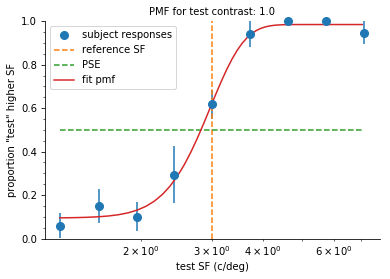

In [21]:
# now plot the PMF
whichCon = 3;
x = np.arange(sfVals[0], sfVals[-1], 0.1)
true_pmf = lambda params: params[2] + (1-params[2]-params[3])*norm.cdf(x, *params[0:2])

pts = plt.errorbar(sfVals, ptSf[whichCon], yerr=bootPtSfstd[whichCon, :], clip_on=False, linestyle='none', marker='o');
refSFline = plt.semilogx([refSF, refSF], [0, 1], '--'); 
pse = plt.semilogx([sfVals[0], sfVals[-1]], [0.5, 0.5], '--')
pmf = plt.semilogx(x, true_pmf(params[whichCon, :]), '-');
plt.ylim([0, 1]);
plt.xlabel('test SF (c/deg)');
plt.ylabel('proportion "test" higher SF');
plt.legend((pts[0], refSFline[0], pse[0], pmf[0]), ('subject responses', 'reference SF', 'PSE', 'fit pmf'));
plt.title('PMF for test contrast: ' + str(conVals[whichCon]));

In [ ]:
# was the subject correct?
corr1 = s1g & (allResp == stim1)
corr2 = s2g & (allResp == stim2)
corrOvr = corr1 | corr2

In [ ]:
testCons = np.zeros(data.shape[0])
testCons[ref==1] = data[ref==1, nInd+conIdx];
testCons[ref==2] = data[ref==2, conIdx];

In [ ]:
pCon = np.zeros(len(conVals))
for con in range(len(conVals)):
    pCon[con] = sum(corrOvr[testCons == conVals[con]]) / sum(testCons==conVals[con])

In [ ]:
testSfs = np.zeros(data.shape[0])
testSfs[ref==1] = data[ref==1, nInd+sfIdx];
testSfs[ref==2] = data[ref==2, sfIdx];

In [ ]:
pSf = np.zeros(len(sfVals))
for sf in range(len(sfVals)):
    pSf[sf] = sum(corrOvr[testSfs == sfVals[sf]]) / sum(testSfs==sfVals[sf])

In [ ]:
ptSf[0]